In [1]:
#######################################
########## IMPORTS ####################
from localLibrary_AWSConnector import *
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import cluster
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.pyplot as plt


# Data Cleaning & Exploration

In [2]:
#HELPER FUNCTIONS

#Returns dictionary of dataframes
def get_data_s3():
    data_list = []
    data_dict = {}

    # Iterate through all buckets
    for bucket in s3.buckets.all():
        # Iterate through all items
        for obj in s3.Bucket(bucket.name).objects.all():
            if('data/' in obj.key and obj.key != 'data/'):
                data_list.append(obj.key)
                
                # Save STM files as DataFrames
                #if('STM' in obj.key and 'non' not in obj.key): 
                objct = s3.Bucket(bucket.name).Object(obj.key).get()
                data_dict[obj.key] = pd.read_csv(objct['Body'], index_col=0)

    print(data_list)
    
    return data_dict

#Convert time helper
def _convert_time_to_int(time):
    #print(time)
    if time != time:
        return None
    else:
        return int(''.join(c for c in time if c.isdigit()))

#convert date columns to int  for given df   
def convert_time_int(df):
    
    df['EarliestCRM_int'] = [_convert_time_to_int(x) for x in df['EarliestCRM']]
    df['LatestCRM_int'] = [_convert_time_to_int(x) for x in df['LatestCRM']]

    df['LatestSeatGeek_int'] = [_convert_time_to_int(x) for x in df['LatestSeatGeekDate']]
    df['EarliestSeatGeek_int'] = [_convert_time_to_int(x) for x in df['EarliestSeatGeekDate']]

    df['EarliestMarketo_int'] = [_convert_time_to_int(x) for x in df['EarliestMarketoDate']]
    df['LatestMarketo_int'] = [_convert_time_to_int(x) for x in df['LatestMarketoDate']]

    df['EarliestFanatics_int'] = [_convert_time_to_int(x) for x in df['EarliestFanaticsDate']]
    df['LatestFanatics_int'] = [_convert_time_to_int(x) for x in df['LatestFanaticsDate']]

    df['EarliestYinzcam_int'] = [_convert_time_to_int(x) for x in df['EarliestYinzcamDate']]
    df['LatestYinzcam_int'] = [_convert_time_to_int(x) for x in df['LatestYinzcamDate']]
    
    return df

#Creates date difference column (latest - earliest)
def calculate_time_diff(df):
    
    df['CRM_diff'] = df['LatestCRM_int'] - df['EarliestCRM_int']
    df['SeatGeek_diff'] = df['LatestSeatGeek_int'] - df['EarliestSeatGeek_int']
    df['Marketo_diff'] = df['LatestMarketo_int'] - df['EarliestMarketo_int']
    df['Fanatics_diff'] = df['LatestFanatics_int'] - df['EarliestFanatics_int']
    df['Yinzcam_diff'] = df['LatestYinzcam_int'] - df['EarliestYinzcam_int']
    
    return df

In [3]:
all_data = get_data_s3()

['data/CRM_STM.csv', 'data/CRM_lost.csv', 'data/CRM_nonSTM.csv', 'data/FTS_STM.csv', 'data/FTS_lost.csv', 'data/FTS_nonSTM.csv', 'data/MK_STM.csv', 'data/MK_lost.csv', 'data/MK_nonSTM.csv', 'data/SG_STM.csv', 'data/SG_lost.csv', 'data/SG_nonSTM.csv', 'data/YZ_STM.csv', 'data/YZ_lost.csv', 'data/YZ_nonSTM.csv']


In [4]:
all_data.keys()

dict_keys(['data/CRM_STM.csv', 'data/CRM_lost.csv', 'data/CRM_nonSTM.csv', 'data/FTS_STM.csv', 'data/FTS_lost.csv', 'data/FTS_nonSTM.csv', 'data/MK_STM.csv', 'data/MK_lost.csv', 'data/MK_nonSTM.csv', 'data/SG_STM.csv', 'data/SG_lost.csv', 'data/SG_nonSTM.csv', 'data/YZ_STM.csv', 'data/YZ_lost.csv', 'data/YZ_nonSTM.csv'])

In [5]:
for key in all_data.keys():
    print(key)
    print(all_data[key].describe(include='all'))
    print("=====================================================")

data/CRM_STM.csv
        TotalCRMActivityVolume          EarliestCRM            LatestCRM
count              3149.000000                 3149                 3149
unique                     NaN                 2016                 3107
top                        NaN  2009-05-21 01:29:13  2009-05-21 01:29:13
freq                       NaN                  916                   25
mean                 12.091458                  NaN                  NaN
std                  10.898481                  NaN                  NaN
min                   1.000000                  NaN                  NaN
25%                   3.000000                  NaN                  NaN
50%                   8.000000                  NaN                  NaN
75%                  20.000000                  NaN                  NaN
max                  94.000000                  NaN                  NaN
data/CRM_lost.csv
        TotalCRMActivityVolume          EarliestCRM            LatestCRM
count           

        TotalMarketoVolume  EarliestMarketoDate    LatestMarketoDate
count         59689.000000                59689                59689
unique                 NaN                56621                56727
top                    NaN  2017-02-14 17:40:22  2020-08-19 00:34:19
freq                   NaN                   26                   14
mean             39.566537                  NaN                  NaN
std              96.149646                  NaN                  NaN
min               1.000000                  NaN                  NaN
25%               5.000000                  NaN                  NaN
50%              15.000000                  NaN                  NaN
75%              42.000000                  NaN                  NaN
max           11706.000000                  NaN                  NaN
data/MK_nonSTM.csv
        TotalMarketoVolume  EarliestMarketoDate    LatestMarketoDate
count        598696.000000               598696               598696
unique         

In [6]:
#MERGE all DF for STM
STM = None
nonSTM = None
lost = None


for key in all_data.keys():
    df = all_data[key]
    how = 'outer'
    if 'SG' in key:
        pivoted = pd.pivot_table(all_data[key], values=['TotalSeatGeekTransactions', 'TotalTicketVolume', 'TotalScannedTicketVolume', 'TotalTicketDollarValue'], index=['SSB_CRMSYSTEM_CONTACT_ID'],
                    columns=['cjsgActivityType', 'cjsgSecondaryTicketType'], aggfunc=np.sum)
        df = pd.DataFrame(pivoted.to_records())
        sg = pd.DataFrame()
        sg['SSB_CRMSYSTEM_CONTACT_ID'] = df['SSB_CRMSYSTEM_CONTACT_ID']
        sg['total_scanned'] = df["('TotalScannedTicketVolume', 'Purchase', 'Primary')"] + df["('TotalScannedTicketVolume', 'Purchase', 'Resale')"] + df["('TotalScannedTicketVolume', 'Purchase', 'Transfer')"]

        sg['primary_purchase_transactions'] = df["('TotalSeatGeekTransactions', 'Purchase', 'Primary')"]
        sg['secondary_purchase_transactions'] = df["('TotalSeatGeekTransactions', 'Purchase', 'Resale')"] + df["('TotalSeatGeekTransactions', 'Purchase', 'Transfer')"]
        sg['secondary_sell_transactions'] = df["('TotalSeatGeekTransactions', 'Sell', 'Resale')"] + df["('TotalSeatGeekTransactions', 'Sell', 'Transfer')"]

        sg['primary_purchase_dollars'] = df["('TotalTicketDollarValue', 'Purchase', 'Primary')"]
        sg['secondary_purchase_dollars'] = df["('TotalTicketDollarValue', 'Purchase', 'Resale')"] + df["('TotalTicketDollarValue', 'Purchase', 'Transfer')"]
        sg['secondary_sell_dollars'] = df["('TotalTicketDollarValue', 'Sell', 'Resale')"] + df["('TotalTicketDollarValue', 'Sell', 'Transfer')"]

        sg['primary_purchase_tickets'] = df["('TotalTicketVolume', 'Purchase', 'Primary')"]
        sg['secondary_purchase_tickets'] = df["('TotalTicketVolume', 'Purchase', 'Resale')"] + df["('TotalTicketVolume', 'Purchase', 'Transfer')"]
        sg['secondary_sell_tickets'] = df["('TotalTicketVolume', 'Sell', 'Resale')"] + df["('TotalTicketVolume', 'Sell', 'Transfer')"]
        
        df = sg
        df = df.merge(all_data[key][['EarliestSeatGeekDate' ,'LatestSeatGeekDate']], on = 'SSB_CRMSYSTEM_CONTACT_ID')
        how = 'right'
        
    if('STM' in key and 'non' not in key): 
        if STM is None:
            STM = df
        else:
            STM = STM.merge(df, how = how, on = 'SSB_CRMSYSTEM_CONTACT_ID')
    elif('non' in key): 
        if nonSTM is None:
            nonSTM = df
        else:
            nonSTM = nonSTM.merge(df, how = how, on = 'SSB_CRMSYSTEM_CONTACT_ID')
    elif('lost' in key): 
        if lost is None:
            lost = df
        else:
            lost = lost.merge(df, how = how, on = 'SSB_CRMSYSTEM_CONTACT_ID')
    else:
        pass

In [7]:
stm_null = pd.DataFrame(STM.isna().sum()/len(STM), columns = ['STM_Pct_Null'])
nonstm_null = pd.DataFrame(nonSTM.isna().sum()/len(nonSTM), columns = ['nonSTM_Pct_Null'])
lost_null = pd.DataFrame(lost.isna().sum()/len(lost), columns = ['lost_Pct_Null'])

all_null = stm_null.merge(nonstm_null.merge(lost_null, left_index=True, right_index=True), left_index=True, right_index=True)

In [8]:
#CONVERT DATE COLUMNS TO INT

STM = convert_time_int(STM)
nonSTM = convert_time_int(nonSTM)
lost = convert_time_int(lost)

#CALCULATE DATE DIFFERENCE
#QUANTIFY LENGTH OF ENGAGEMENT

STM = calculate_time_diff(STM)
nonSTM = calculate_time_diff(nonSTM)
lost = calculate_time_diff(lost)


In [9]:
print(f"STM Length: {len(STM)}")
print(f"nonSTM Length: {len(nonSTM)}")
print(f"lost Length: {len(lost)}")


STM Length: 2250
nonSTM Length: 133188
lost Length: 20669


In [10]:
all_null.sort_values(by = 'STM_Pct_Null', ascending = True)

,STM_Pct_Null,nonSTM_Pct_Null,lost_Pct_Null
SSB_CRMSYSTEM_CONTACT_ID,0.000000,0.000008,0.000000
LatestSeatGeekDate,0.008889,0.044171,0.027481
EarliestSeatGeekDate,0.008889,0.044171,0.027481
primary_purchase_tickets,0.080000,0.575390,0.534665
primary_purchase_dollars,0.080000,0.575390,0.534665
primary_purchase_transactions,0.080000,0.575390,0.534665
TotalCRMActivityVolume,0.103556,0.203840,0.041270
EarliestCRM,0.103556,0.203840,0.041270
LatestCRM,0.103556,0.203840,0.041270
TotalMarketoVolume,0.126667,0.345857,0.142048


In [11]:
#DROP DATE COLUMNS
for col in STM.columns:
    if 'Date' in col:
        print(col)
        STM.drop([col], axis=1, inplace = True)
        nonSTM.drop([col], axis=1, inplace = True)
        lost.drop([col], axis=1, inplace = True)
    else:
        pass

STM.drop(['EarliestCRM', 'LatestCRM'], axis=1, inplace = True)
nonSTM.drop(['EarliestCRM', 'LatestCRM'], axis=1, inplace = True)
lost.drop(['EarliestCRM', 'LatestCRM'], axis=1, inplace = True) 

EarliestFanaticsDate
LatestFanaticsDate
EarliestMarketoDate
LatestMarketoDate
EarliestSeatGeekDate
LatestSeatGeekDate
EarliestYinzcamDate
LatestYinzcamDate


In [12]:
#PERCENT OF ROWS WITH MISSING VALUES
print(f"STM: {(STM.shape[0] - STM.dropna().shape[0])/len(STM)}")
print(f"nonSTM: {(nonSTM.shape[0] - nonSTM.dropna().shape[0])/len(nonSTM)}")
print(f"lost: {(lost.shape[0] - lost.dropna().shape[0])/len(lost)}")


STM: 1.0
nonSTM: 0.9986860678139172
lost: 0.9980647346267357


In [14]:
#DROP COLUMNS
columns = []
for col in STM.columns:
    if 'scanned' in col:
        STM.drop([col], axis=1, inplace = True)
        nonSTM.drop([col], axis=1, inplace = True)
        lost.drop([col], axis=1, inplace = True)
    elif 'secondary' in col:
        STM.drop([col], axis=1, inplace = True)
        nonSTM.drop([col], axis=1, inplace = True)
        lost.drop([col], axis=1, inplace = True)
    elif 'Yinz' in col:
        STM.drop([col], axis=1, inplace = True)
        nonSTM.drop([col], axis=1, inplace = True)
        lost.drop([col], axis=1, inplace = True)
    elif 'Fanatics' in col:
        STM.drop([col], axis=1, inplace = True)
        nonSTM.drop([col], axis=1, inplace = True)
        lost.drop([col], axis=1, inplace = True)
    else:
        pass
    
#NUMBER OF ROWS WITHOUT MISSING VALUES
print(f"STM full rows count: {(STM.dropna().shape[0])}")
print(f"nonSTM full rows count: {(nonSTM.dropna().shape[0])}")
print(f"lost full rows count: {(lost.dropna().shape[0])}")

STM full rows count: 1727
nonSTM full rows count: 43191
lost full rows count: 8815


# Visualize Data Distributions

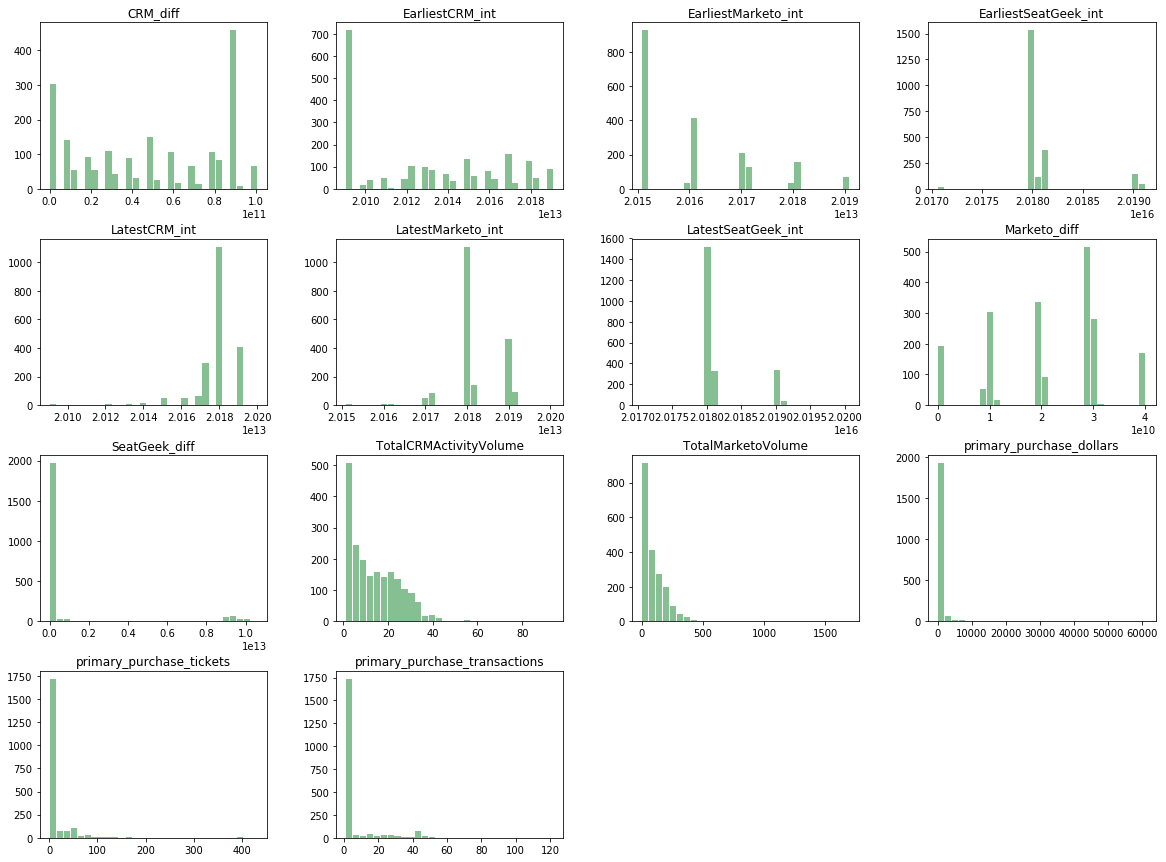

In [15]:
ax = STM.hist(bins=30, grid=False, figsize=(20,15), color='#86bf91', zorder=2, rwidth=0.9)

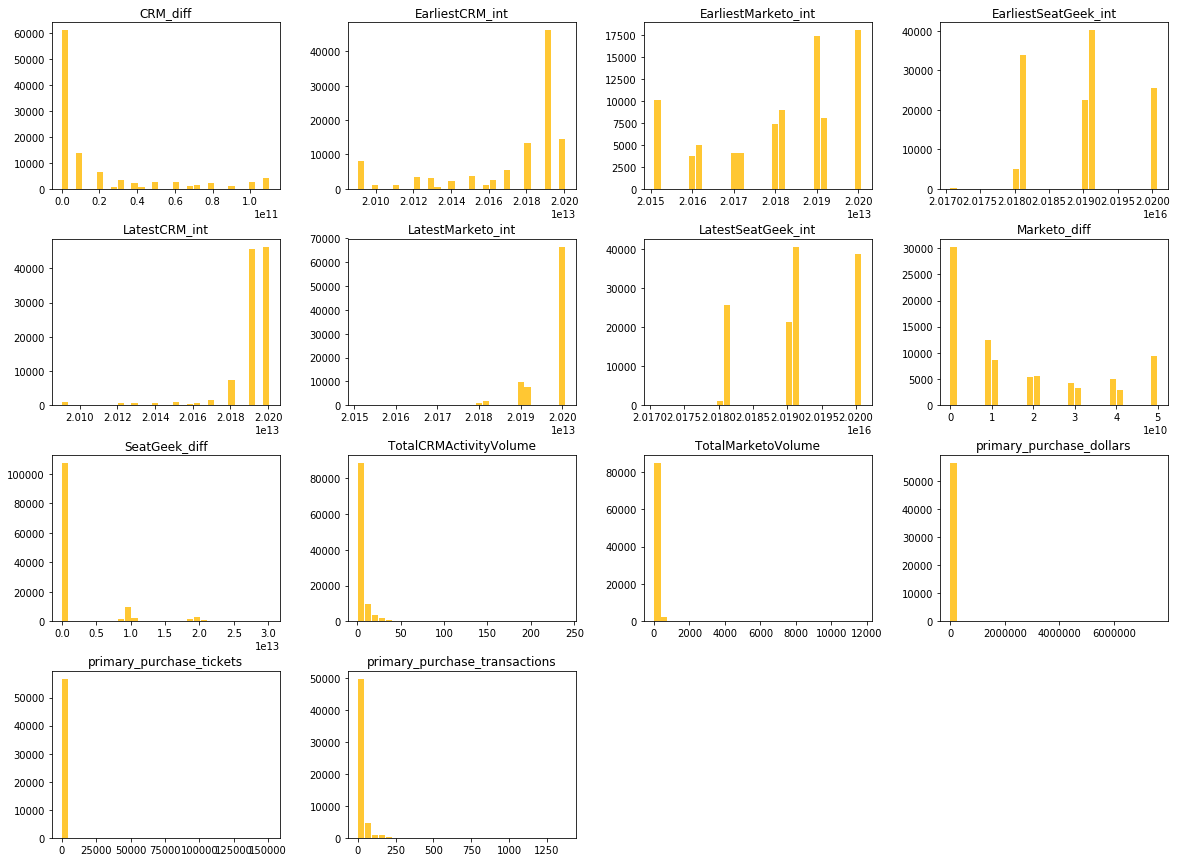

In [16]:
ax = nonSTM.hist(bins=30, grid=False, figsize=(20,15), color='#FFC733', zorder=2, rwidth=0.9)

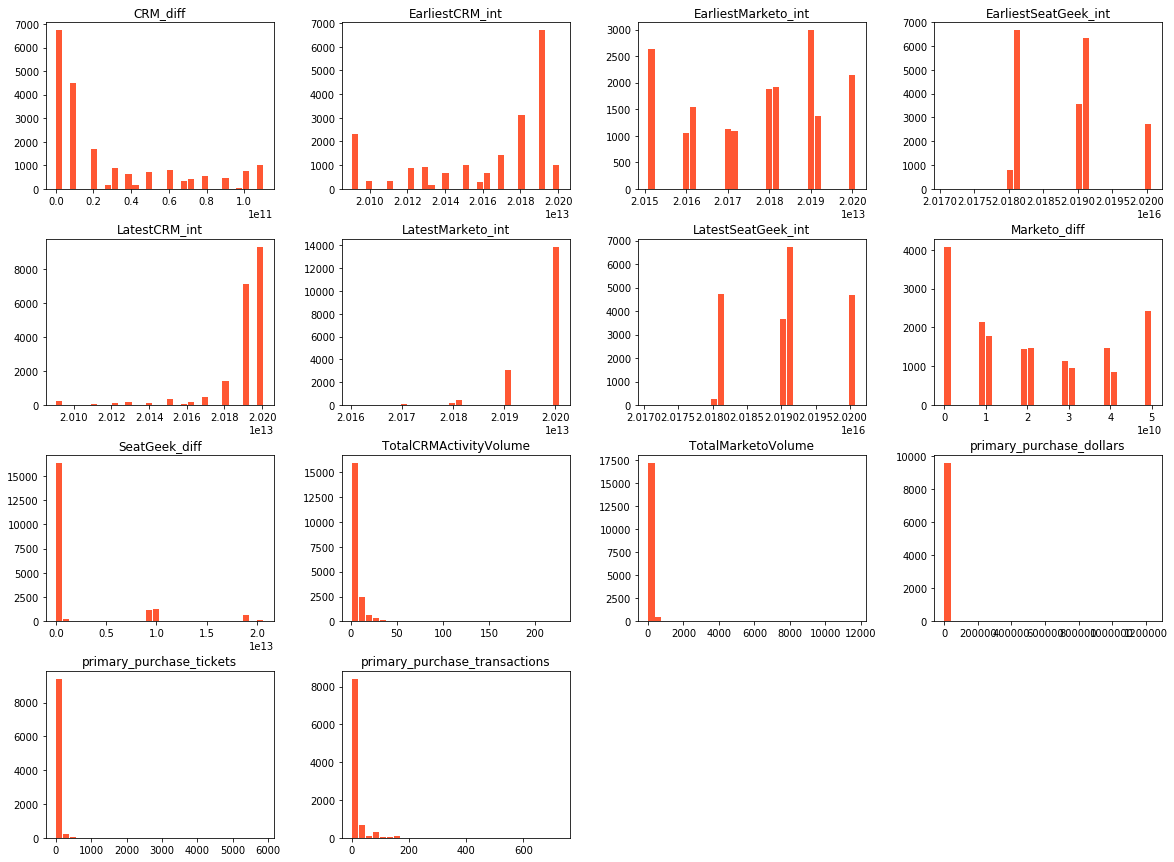

In [17]:
ax = lost.hist(bins=30, grid=False, figsize=(20,15), color='#FF5733', zorder=2, rwidth=0.9)

# Standardization & PCA

In [115]:
#STACK STM NONSTM, LOST

STM['target'] = 'STM'
lost['target'] = 'Rejecter'
nonSTM['target'] = 'nonSTM'

full_data = pd.concat([STM, nonSTM, lost])

In [19]:
#STANDARDIZE FEATURES

full_tmp = full_data.drop(['SSB_CRMSYSTEM_CONTACT_ID', 'target'], axis = 1).dropna()

scaler = StandardScaler()
scaler.fit(full_tmp)

full_standardized  = pd.DataFrame(scaler.transform(full_tmp))

In [34]:
#PCA

#PCA CLUSTERING
np.set_printoptions(precision=2, suppress=True)

#DECIDED ON # of Components = 5 to represent > 75% of variance
pca = PCA()
pca.fit(full_standardized)
np.cumsum(pca.explained_variance_/sum(pca.explained_variance_))

array([0.3 , 0.46, 0.6 , 0.68, 0.76, 0.83, 0.88, 0.93, 0.97, 1.  , 1.  ,
       1.  , 1.  , 1.  ])

In [35]:
#DECIDED ON # of Components = 5 to represent > 75% of variance
pca = PCA(n_components=5)
pca.fit(full_standardized)

PCA(copy=True, iterated_power='auto', n_components=5, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [28]:
#BUILD ATTRIBUTES INFO FOR PCA INTERPRETATION
# full_tmp.columns
attributes_info = pd.DataFrame(columns = ['Attribute', 'Description'])
attributes_info = attributes_info.append({'Attribute':0, 'Description': 'TotalCRMAcvtivty Volume'}, ignore_index = True)
attributes_info = attributes_info.append({'Attribute':1, 'Description': 'TotalMarketoVolume'}, ignore_index = True)
attributes_info = attributes_info.append({'Attribute':2, 'Description': 'primary_purchase_transactions'}, ignore_index = True)
attributes_info = attributes_info.append({'Attribute':3, 'Description': 'primary_purchase_dollars'}, ignore_index = True)
attributes_info = attributes_info.append({'Attribute':4, 'Description': 'primary_purchase_tickets'}, ignore_index = True)
attributes_info = attributes_info.append({'Attribute':5, 'Description': 'EarliestCRM_int'}, ignore_index = True)
attributes_info = attributes_info.append({'Attribute':6, 'Description': 'LatestCRM_int'}, ignore_index = True)
attributes_info = attributes_info.append({'Attribute':7, 'Description': 'LatestSeatGeek_int'}, ignore_index = True)
attributes_info = attributes_info.append({'Attribute':8, 'Description': 'EarliestSeatGeek_int'}, ignore_index = True)
attributes_info = attributes_info.append({'Attribute':9, 'Description': 'EarliestMarketo_int'}, ignore_index = True)
attributes_info = attributes_info.append({'Attribute':10, 'Description': 'LatestMarketo_int'}, ignore_index = True)
attributes_info = attributes_info.append({'Attribute':11, 'Description': 'CRM_diff'}, ignore_index = True)
attributes_info = attributes_info.append({'Attribute':12, 'Description': 'SeatGeek_diff'}, ignore_index = True)
attributes_info = attributes_info.append({'Attribute':13, 'Description': 'Marketo_diff'}, ignore_index = True)
attributes_info

,Attribute,Description
0,0,TotalCRMAcvtivty Volume
1,1,TotalMarketoVolume
2,2,primary_purchase_transactions
3,3,primary_purchase_dollars
4,4,primary_purchase_tickets
5,5,EarliestCRM_int
6,6,LatestCRM_int
7,7,LatestSeatGeek_int
8,8,EarliestSeatGeek_int
9,9,EarliestMarketo_int


In [29]:
#PCA

def plot_feature_weights(df, pca, attributes_info, dimension, n_weights = 5, plot=True,figsize=(7,8)):
    """
    This function displays interesting features of the selected dimension
    """
    
    features = df.columns.values
    components = pca.components_
    feature_weights = dict(zip(features, components[dimension]))
    sorted_weights = sorted(feature_weights.items(), key = lambda kv: kv[1])
    
    feat_names = []
    feat_weights = []
    feat_descs = []

    for feature, weight in sorted_weights[-n_weights:]:
        feat_names.append(feature)
        feat_weights.append(weight)
        
    for feature, weight, in sorted_weights[:n_weights]:
        feat_names.append(feature)
        feat_weights.append(weight)
        
    for feature in feat_names:
        if feature in attributes_info.Attribute.values:
            feat_descs.append(attributes_info[attributes_info.Attribute == feature].Description.values[0])
        else:
            feat_descs.append("No description given")
    
    component_info = {"Feature":feat_names, "Description":feat_descs, "FeatureWeight":feat_weights}
    component_info = pd.DataFrame(component_info)
    component_info.sort_values(by =["FeatureWeight"], inplace=True, ascending=False)
           
    if plot:
        fig = plt.figure(figsize=figsize)

        ax = fig.add_subplot(211)
        ax.bar(feat_names, feat_weights)
        ax.set_ylabel("Feature Weight")
        ax.set_xlabel("Feature Name")
        ax.set_title("PCA Feature weights - Component {}".format(dimension))
        for tick in ax.get_xticklabels():
            tick.set_rotation(45)
        ax.grid()

        fig.tight_layout()
        plt.show()
    
    return component_info

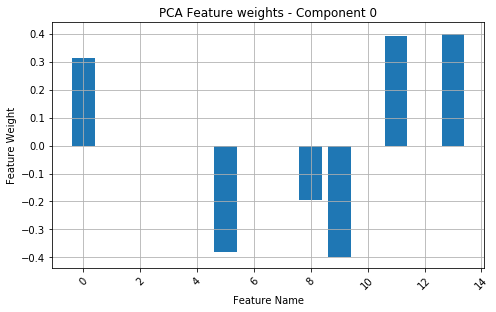

,Feature,Description,FeatureWeight
2,13,Marketo_diff,0.400446
1,11,CRM_diff,0.392863
0,0,TotalCRMAcvtivty Volume,0.311544
5,8,EarliestSeatGeek_int,-0.195185
4,5,EarliestCRM_int,-0.380155
3,9,EarliestMarketo_int,-0.397060


In [30]:
component_0_info = plot_feature_weights(full_standardized, pca, attributes_info, 0, 3)
component_0_info.head(10)

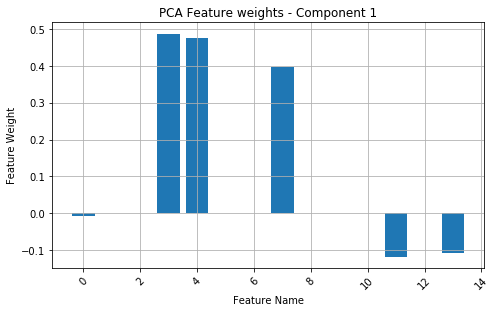

,Feature,Description,FeatureWeight
2,3,primary_purchase_dollars,0.487483
1,4,primary_purchase_tickets,0.474813
0,7,LatestSeatGeek_int,0.396600
5,0,TotalCRMAcvtivty Volume,-0.006402
4,13,Marketo_diff,-0.108223
3,11,CRM_diff,-0.117550


In [31]:
component_1_info = plot_feature_weights(full_standardized, pca, attributes_info, 1, 3)
component_1_info.head(10)

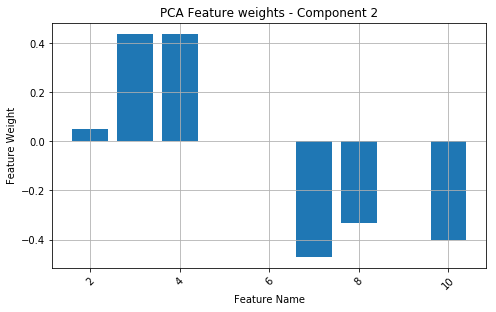

,Feature,Description,FeatureWeight
2,4,primary_purchase_tickets,0.438192
1,3,primary_purchase_dollars,0.435434
0,2,primary_purchase_transactions,0.050515
5,8,EarliestSeatGeek_int,-0.334296
4,10,LatestMarketo_int,-0.400434
3,7,LatestSeatGeek_int,-0.469468


In [32]:
component_2_info = plot_feature_weights(full_standardized, pca, attributes_info, 2, 3)
component_2_info.head(10)

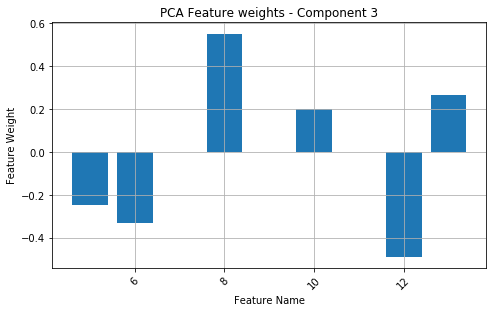

,Feature,Description,FeatureWeight
2,8,EarliestSeatGeek_int,0.551229
1,13,Marketo_diff,0.263317
0,10,LatestMarketo_int,0.197801
5,5,EarliestCRM_int,-0.246706
4,6,LatestCRM_int,-0.333238
3,12,SeatGeek_diff,-0.487924


In [33]:
component_3_info = plot_feature_weights(full_standardized, pca, attributes_info, 3, 3)
component_3_info.head(10)

# Unsupervised: Clustering STM and Lost

For n_clusters = 2 The average silhouette_score is : 0.39777396902799395
For n_clusters = 3 The average silhouette_score is : 0.3704759201697665
For n_clusters = 4 The average silhouette_score is : 0.3731573669407578
For n_clusters = 5 The average silhouette_score is : 0.38345163932447335
For n_clusters = 6 The average silhouette_score is : 0.30214358542793907
For n_clusters = 7 The average silhouette_score is : 0.3165542471966172
For n_clusters = 8 The average silhouette_score is : 0.33627555269200493
For n_clusters = 9 The average silhouette_score is : 0.29490364632381755


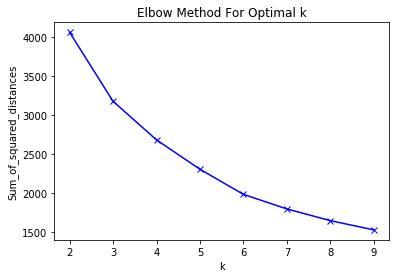

In [36]:
##STM CLUSTERING

df = STM.drop(['SSB_CRMSYSTEM_CONTACT_ID', 'target'], axis = 1).dropna()
stm_standardized  = pd.DataFrame(scaler.transform(df))
stm_pca = pca.transform(stm_standardized)


Sum_of_squared_distances = []
K = range(2,10)
for k in K:
    km = cluster.KMeans(n_clusters=k)
    km = km.fit(stm_pca)
    Sum_of_squared_distances.append(km.inertia_)
    cluster_labels = km.labels_
    silhouette_avg = silhouette_score(stm_pca, cluster_labels)
    print("For n_clusters =", k,
          "The average silhouette_score is :", silhouette_avg)
    
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [37]:
##STM CLUSTERING 
k = 5
stm_kmeans = cluster.KMeans(n_clusters=k)
stm_kmeans.fit(stm_pca)

train_labels = stm_kmeans.predict(stm_pca)
stm_pred  = pd.DataFrame(stm_pca)
stm_pred['Cluster'] = train_labels
stm_pred['Cluster'].value_counts()

1    840
0    420
3    213
4    171
2     83
Name: Cluster, dtype: int64

In [38]:
##APPLY STM CLUSTERING to NONSTM
df = nonSTM.drop(['SSB_CRMSYSTEM_CONTACT_ID', 'target'], axis = 1).dropna()
nonstm_standardized  = pd.DataFrame(scaler.transform(df))
nonstm_pca = pca.transform(nonstm_standardized)

train_labels = stm_kmeans.predict(nonstm_pca)
nonstm_pred  = pd.DataFrame(nonstm_pca)
nonstm_pred['Cluster_STM'] = train_labels
nonstm_pred['Cluster_STM'].value_counts()

4    25017
3    16186
2      976
0      695
1      317
Name: Cluster_STM, dtype: int64

For n_clusters = 2 The average silhouette_score is : 0.3171754422003077
For n_clusters = 3 The average silhouette_score is : 0.34377436091952196
For n_clusters = 4 The average silhouette_score is : 0.2960411071639063
For n_clusters = 5 The average silhouette_score is : 0.30451569134837064
For n_clusters = 6 The average silhouette_score is : 0.2950611329357076
For n_clusters = 7 The average silhouette_score is : 0.31691682843134306
For n_clusters = 8 The average silhouette_score is : 0.3111485976883387
For n_clusters = 9 The average silhouette_score is : 0.2978357828208367


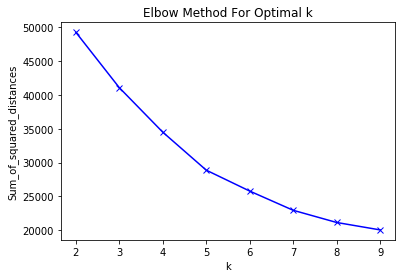

In [39]:
##LOST CLUSTERING

df = lost.drop(['SSB_CRMSYSTEM_CONTACT_ID', 'target'], axis = 1).dropna()
lost_standardized  = pd.DataFrame(scaler.transform(df))
lost_pca = pca.transform(lost_standardized)

Sum_of_squared_distances = []
K = range(2,10)
for k in K:
    km = cluster.KMeans(n_clusters=k)
    km = km.fit(lost_pca)
    Sum_of_squared_distances.append(km.inertia_)
    cluster_labels = km.labels_
    silhouette_avg = silhouette_score(lost_pca, cluster_labels)
    print("For n_clusters =", k,
          "The average silhouette_score is :", silhouette_avg)
    
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [40]:
##LOST CLUSTERING 
k = 5
lost_kmeans = cluster.KMeans(n_clusters=k)
lost_kmeans.fit(stm_pca)

train_labels = lost_kmeans.predict(lost_pca)
lost_pred  = pd.DataFrame(lost_pca)
lost_pred['Cluster'] = train_labels
lost_pred['Cluster'].value_counts()

3    4294
0    4153
2     188
1     122
4      58
Name: Cluster, dtype: int64

In [41]:
##APPLY LOST CLUSTERING to NONSTM
df = nonSTM.drop(['SSB_CRMSYSTEM_CONTACT_ID', 'target'], axis = 1).dropna()
nonstm_standardized  = pd.DataFrame(scaler.transform(df))
nonstm_pca = pca.transform(nonstm_standardized)

train_labels = lost_kmeans.predict(nonstm_pca)
#nonstm_pred  = pd.DataFrame(nonstm_pca)
nonstm_pred['Cluster_lost'] = train_labels
nonstm_pred['Cluster_lost'].value_counts()

3    23946
0    17759
2      866
1      447
4      173
Name: Cluster_lost, dtype: int64

In [42]:
cluster_info = pd.DataFrame([])

cluster_info["STM"] = stm_pred['Cluster'].value_counts().sort_index()
cluster_info["Population_STM"] = nonstm_pred['Cluster_STM'].value_counts().sort_index()
cluster_info["Lost"] = lost_pred['Cluster'].value_counts().sort_index()
cluster_info["Population_Lost"] = nonstm_pred['Cluster_lost'].value_counts().sort_index()
cluster_info.reset_index(inplace=True)
cluster_info.rename(columns={"index":"Cluster"}, inplace=True)

In [43]:
cluster_info


,Cluster,STM,Population_STM,Lost,Population_Lost
0,0,420,695,4153,17759
1,1,840,317,122,447
2,2,83,976,188,866
3,3,213,16186,4294,23946
4,4,171,25017,58,173


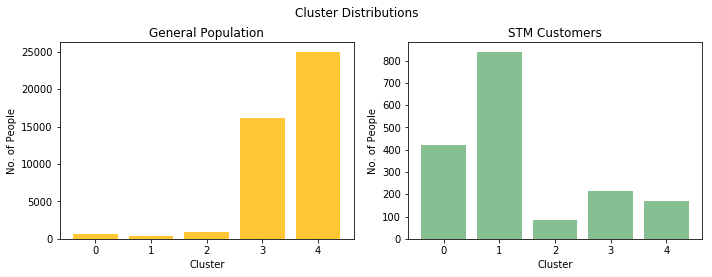

In [48]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10, 4))

ax1.bar(cluster_info["Cluster"], cluster_info["Population_STM"], color=(255/255, 199/255, 51/255))
ax1.set_xlabel("Cluster")
ax1.set_ylabel("No. of People")
ax1.set_title("General Population")

ax2.bar(cluster_info["Cluster"], cluster_info["STM"], color=(134/255, 191/255, 145/255))
ax2.set_xlabel("Cluster")
ax2.set_ylabel("No. of People")
ax2.set_title("STM Customers")

fig.suptitle("Cluster Distributions")
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

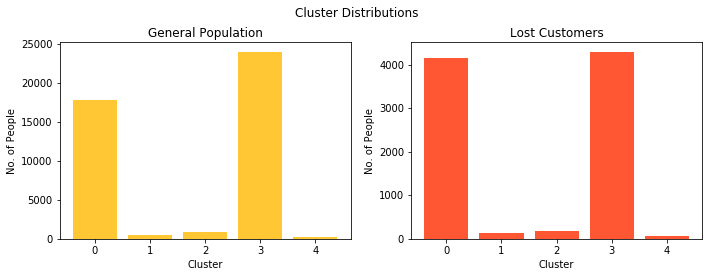

In [49]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10, 4))

ax1.bar(cluster_info["Cluster"], cluster_info["Population_Lost"], color=(255/255, 199/255, 51/255))
ax1.set_xlabel("Cluster")
ax1.set_ylabel("No. of People")
ax1.set_title("General Population")

ax2.bar(cluster_info["Cluster"], cluster_info["Lost"], color=(255/255, 87/255, 51/255))
ax2.set_xlabel("Cluster")
ax2.set_ylabel("No. of People")
ax2.set_title("Lost Customers")

fig.suptitle("Cluster Distributions")
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [50]:
cluster_info["Population_STM_proportion"] = (cluster_info["Population_STM"]/cluster_info["Population_STM"].sum()*100).round(2)
cluster_info["STM_proportion"] = (cluster_info["STM"]/cluster_info["STM"].sum()*100).round(2)
cluster_info["Population_Lost_proportion"] = (cluster_info["Population_Lost"]/cluster_info["Population_Lost"].sum()*100).round(2)
cluster_info["Lost_proportion"] = (cluster_info["Lost"]/cluster_info["Lost"].sum()*100).round(2)

cluster_info["STM_over_Pop"] = cluster_info["STM_proportion"] / cluster_info["Population_STM_proportion"]
cluster_info["Lost_over_Pop"] = cluster_info["Lost_proportion"] / cluster_info["Population_Lost_proportion"]



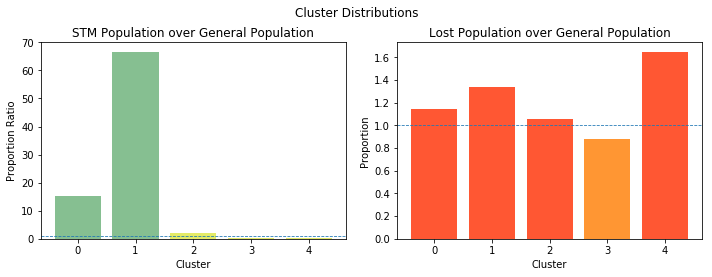

In [79]:
fig, (ax, ax2) = plt.subplots(1,2, figsize=(10, 4))

mask1 = cluster_info["STM_over_Pop"] < 10
mask2 = cluster_info["STM_over_Pop"] >= 10

ax.bar(cluster_info["Cluster"][mask1], cluster_info["STM_over_Pop"][mask1], color=(228/255, 235/255, 103/255))
ax.bar(cluster_info["Cluster"][mask2], cluster_info["STM_over_Pop"][mask2], color=(134/255, 191/255, 145/255))

ax.set_xlabel("Cluster")
ax.set_ylabel("Proportion Ratio")
ax.set_title("STM Population over General Population")
ax.axhline(y=1, linestyle = "--", linewidth = 0.8)


mask1 = cluster_info["Lost_over_Pop"] < 1
mask2 = cluster_info["Lost_over_Pop"] >= 1

ax2.bar(cluster_info["Cluster"][mask1], cluster_info["Lost_over_Pop"][mask1], color=(255/255, 150/255, 51/255))
ax2.bar(cluster_info["Cluster"][mask2], cluster_info["Lost_over_Pop"][mask2], color=(255/255, 87/255, 51/255))

ax2.set_xlabel("Cluster")
ax2.set_ylabel("Proportion")
ax2.set_title("Lost Population over General Population")
ax2.axhline(y=1, linestyle = "--", linewidth = 0.8)


fig.suptitle("Cluster Distributions")

fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [57]:
cluster_info

,Cluster,STM,Population_STM,Lost,Population_Lost,Population_STM_proportion,STM_proportion,Population_Lost_proportion,Lost_proportion,STM_over_Pop,Lost_over_Pop
0,0,420,695,4153,17759,1.61,24.32,41.12,47.11,15.105590,1.145671
1,1,840,317,122,447,0.73,48.64,1.03,1.38,66.630137,1.339806
2,2,83,976,188,866,2.26,4.81,2.01,2.13,2.128319,1.059701
3,3,213,16186,4294,23946,37.48,12.33,55.44,48.71,0.328975,0.878608
4,4,171,25017,58,173,57.92,9.90,0.40,0.66,0.170925,1.650000


In [88]:
def explain_cluster(kmeans_model, cluster_no, data, pca_model, attributes_info, num_components=3, num_feat_per_comp=2):
    
    weights = kmeans_model.cluster_centers_[cluster_no]
    components = list(range(len(weights)))
    
    cluster_expl = pd.DataFrame({"Weights":weights, "Component":components})
    cluster_expl.sort_values("Weights", ascending=False, inplace=True)

    comps = []
    weights = []
    comp_infos = []
    for index, row in cluster_expl.head(n=num_components).iterrows():
        
        component_info = plot_feature_weights(data, pca_model, attributes_info, 
                                                int(row["Component"]), num_feat_per_comp, False)
        comp_infos.append(component_info)
        comps += [int(row["Component"])] * len(component_info)
        weights +=  [row["Weights"]] * len(component_info)
        
    component_info = pd.concat(comp_infos, ignore_index=True)
    component_info.insert(0, "ComponentWeight", pd.Series(weights))
    component_info.insert(0, "Component", pd.Series(comps))
        
    return component_info.drop(['Description'], axis = 1)

In [89]:
cluster_0 = explain_cluster(stm_kmeans, 0, nonSTM.drop(['SSB_CRMSYSTEM_CONTACT_ID', 'target'], axis = 1).dropna(), pca, attributes_info)
cluster_0

,Component,ComponentWeight,Feature,FeatureWeight
0,2,2.770606,primary_purchase_tickets,0.438192
1,2,2.770606,primary_purchase_dollars,0.435434
2,2,2.770606,LatestMarketo_int,-0.400434
3,2,2.770606,LatestSeatGeek_int,-0.469468
4,4,0.166138,SeatGeek_diff,0.360994
5,4,0.166138,TotalMarketoVolume,0.165167
6,4,0.166138,CRM_diff,-0.368684
7,4,0.166138,LatestCRM_int,-0.668891
8,0,-0.493537,Marketo_diff,0.400446
9,0,-0.493537,CRM_diff,0.392863


In [90]:
cluster_1 = explain_cluster(stm_kmeans, 1, nonSTM.drop(['SSB_CRMSYSTEM_CONTACT_ID', 'target'], axis = 1).dropna(), pca, attributes_info)
cluster_1

,Component,ComponentWeight,Feature,FeatureWeight
0,2,2.759889,primary_purchase_tickets,0.438192
1,2,2.759889,primary_purchase_dollars,0.435434
2,2,2.759889,LatestMarketo_int,-0.400434
3,2,2.759889,LatestSeatGeek_int,-0.469468
4,0,1.458017,Marketo_diff,0.400446
5,0,1.458017,CRM_diff,0.392863
6,0,1.458017,EarliestCRM_int,-0.380155
7,0,1.458017,EarliestMarketo_int,-0.397060
8,3,-0.159437,EarliestSeatGeek_int,0.551229
9,3,-0.159437,Marketo_diff,0.263317


In [91]:
cluster_4 = explain_cluster(lost_kmeans, 4, nonSTM.drop(['SSB_CRMSYSTEM_CONTACT_ID', 'target'], axis = 1).dropna(), pca, attributes_info)
cluster_4

,Component,ComponentWeight,Feature,FeatureWeight
0,2,2.820374,primary_purchase_tickets,0.438192
1,2,2.820374,primary_purchase_dollars,0.435434
2,2,2.820374,LatestMarketo_int,-0.400434
3,2,2.820374,LatestSeatGeek_int,-0.469468
4,0,0.626971,Marketo_diff,0.400446
5,0,0.626971,CRM_diff,0.392863
6,0,0.626971,EarliestCRM_int,-0.380155
7,0,0.626971,EarliestMarketo_int,-0.397060
8,4,-0.140536,SeatGeek_diff,0.360994
9,4,-0.140536,TotalMarketoVolume,0.165167


In [76]:
cluster_3 = explain_cluster(lost_kmeans, 3, nonSTM.drop(['SSB_CRMSYSTEM_CONTACT_ID', 'target'], axis = 1).dropna(), pca, attributes_info)
cluster_3

,Component,ComponentWeight,Feature,FeatureWeight
0,2,1.119827,primary_purchase_tickets,0.438192
1,2,1.119827,primary_purchase_dollars,0.435434
2,2,1.119827,primary_purchase_transactions,0.050515
3,2,1.119827,EarliestSeatGeek_int,-0.334296
4,2,1.119827,LatestMarketo_int,-0.400434
5,2,1.119827,LatestSeatGeek_int,-0.469468
6,4,0.274335,SeatGeek_diff,0.360994
7,4,0.274335,TotalMarketoVolume,0.165167
8,4,0.274335,Marketo_diff,0.149950
9,4,0.274335,TotalCRMActivityVolume,-0.365279


# Supervised: STM or Lost Classification

In [133]:
#SPLIT full_data
full_data = pd.concat([STM, nonSTM, lost])
full_df = full_data.dropna()
full_df = full_df.loc[full_df['target']!='nonSTM',]
print(full_df['target'].value_counts())
full_df['target'].value_counts()/len(full_df)

Rejecter    8815
STM         1727
Name: target, dtype: int64


Rejecter    0.836179
STM         0.163821
Name: target, dtype: float64

In [193]:
def train_and_predict(model, X_train, y_train, X_test, y_test):
    """
    Fit a model on X_train, y_train
    predicts on X_text, y_test 
    Calculate AUROC on predictions made on test data
    
    Outputs - AUROC score, time elapse for training and prediction    
    """
    #start = time.time()
    model = model.fit(X_train, y_train)
    
    roc_score = roc_auc_score(y_test, model.predict_proba(X_test)[:,1])
    
    #end = time.time()
    #time_elapsed = end - start
    
    return roc_score, 0

In [232]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold # import KFold
from sklearn.model_selection import StratifiedKFold

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
import xgboost as xgb


from sklearn.model_selection import GridSearchCV


from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score


models = [("LogisticRegression", LogisticRegression(random_state=42)),
         ("DecisionTreeClassifier", DecisionTreeClassifier(random_state=42)),
         ("RandomForestClassifier", RandomForestClassifier(random_state=42)),
         ("GradientBoostingClassifier", GradientBoostingClassifier(random_state=42)),
         ("AdaBoostClassifier", AdaBoostClassifier(random_state=42)),
         ("XGBClassifier",xgb.XGBClassifier(random_state=42))]


X = full_df.drop(['SSB_CRMSYSTEM_CONTACT_ID','target'], axis = 1)
y = full_df['target']

#HOLDOUT
#X_use, X_holdout, y_use, y_holdout = train_test_split(X, y, stratify=y, test_size=0.1, random_state=42)
X_use, X_holdout, y_use, y_holdout = train_test_split(X, y, test_size=0.1)

#KFOLD
# kf = StratifiedKFold(n_splits=5) # Define the split - into 5 folds 
# kf.get_n_splits(X_use, y_use) 

kf = KFold(n_splits=5) # Define the split - into 5 folds 
kf.get_n_splits(X_use) 

results = {"Model":[],
          "AUCROC_score":[],
          "Time_in_sec":[]}
for name, model in models:
    roc = 0
    time_ = 0
#     for train_index, test_index in kf.split(X_use, y_use):
    for train_index, test_index in kf.split(X_use):
        print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_test = X_use.iloc[train_index], X_use.iloc[test_index]
        y_train, y_test = y_use.iloc[train_index], y_use.iloc[test_index]
        
        r, t = train_and_predict(model, X_train, y_train, X_test, y_test)
        roc += r
        time_ += t
    results["Model"].append(name)
    results["AUCROC_score"].append(roc/5)
    results["Time_in_sec"].append(time_/5)

#SKLEARN MODELS + PYTORCH MODEL

TRAIN: [1898 1899 1900 ... 9484 9485 9486] TEST: [   0    1    2 ... 1895 1896 1897]
TRAIN: [   0    1    2 ... 9484 9485 9486] TEST: [1898 1899 1900 ... 3793 3794 3795]
TRAIN: [   0    1    2 ... 9484 9485 9486] TEST: [3796 3797 3798 ... 5690 5691 5692]
TRAIN: [   0    1    2 ... 9484 9485 9486] TEST: [5693 5694 5695 ... 7587 7588 7589]


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/s

TRAIN: [   0    1    2 ... 7587 7588 7589] TEST: [7590 7591 7592 ... 9484 9485 9486]
TRAIN: [1898 1899 1900 ... 9484 9485 9486] TEST: [   0    1    2 ... 1895 1896 1897]
TRAIN: [   0    1    2 ... 9484 9485 9486] TEST: [1898 1899 1900 ... 3793 3794 3795]
TRAIN: [   0    1    2 ... 9484 9485 9486] TEST: [3796 3797 3798 ... 5690 5691 5692]
TRAIN: [   0    1    2 ... 9484 9485 9486] TEST: [5693 5694 5695 ... 7587 7588 7589]
TRAIN: [   0    1    2 ... 7587 7588 7589] TEST: [7590 7591 7592 ... 9484 9485 9486]
TRAIN: [1898 1899 1900 ... 9484 9485 9486] TEST: [   0    1    2 ... 1895 1896 1897]
TRAIN: [   0    1    2 ... 9484 9485 9486] TEST: [1898 1899 1900 ... 3793 3794 3795]
TRAIN: [   0    1    2 ... 9484 9485 9486] TEST: [3796 3797 3798 ... 5690 5691 5692]
TRAIN: [   0    1    2 ... 9484 9485 9486] TEST: [5693 5694 5695 ... 7587 7588 7589]
TRAIN: [   0    1    2 ... 7587 7588 7589] TEST: [7590 7591 7592 ... 9484 9485 9486]
TRAIN: [1898 1899 1900 ... 9484 9485 9486] TEST: [   0    1    2 

In [233]:
print(f"Holdout Class Proportion:\n{y_holdout.value_counts()/len(y_holdout)}\n")
print(f"Train Class Proportion:\n{y_train.value_counts()/len(y_train)}\n")
print(f"Test Class Proportion:\n{y_test.value_counts()/len(y_test)}\n")

Holdout Class Proportion:
Rejecter    0.840758
STM         0.159242
Name: target, dtype: float64

Train Class Proportion:
Rejecter    0.832016
STM         0.167984
Name: target, dtype: float64

Test Class Proportion:
Rejecter    0.85029
STM         0.14971
Name: target, dtype: float64



In [234]:
results = pd.DataFrame.from_dict(results, orient='index').transpose()
results

,Model,AUCROC_score,Time_in_sec
0,LogisticRegression,0.5,0
1,DecisionTreeClassifier,0.976922,0
2,RandomForestClassifier,0.998801,0
3,GradientBoostingClassifier,0.998982,0
4,AdaBoostClassifier,0.998295,0
5,XGBClassifier,0.999233,0


In [199]:
model = xgb.XGBClassifier(random_state=42).fit(X_use, y_use)

In [241]:
roc_score = roc_auc_score(y_holdout, model.predict_proba(X_holdout)[:,1])
roc_score

0.9997785472700917

In [253]:
from sklearn.metrics import recall_score
recall_score(y_holdout[y_holdout!='STM'], model.predict(X_holdout[y_holdout!='STM']), pos_label='Rejecter')

0.9977452085682075

In [252]:
from sklearn.metrics import precision_score
precision_score(y_holdout[y_holdout!='STM'], model.predict(X_holdout[y_holdout!='STM']), pos_label='Rejecter')

1.0

In [243]:
y_holdout.value_counts()/len(y_holdout)

Rejecter    0.840758
STM         0.159242
Name: target, dtype: float64

In [255]:
pd.Series(model.predict(X_holdout[y_holdout!='STM'])).value_counts()/len(model.predict(X_holdout[y_holdout!='STM']))

Rejecter    0.997745
STM         0.002255
dtype: float64

In [247]:
nonSTMnew = nonSTM.drop(['SSB_CRMSYSTEM_CONTACT_ID','target'], axis = 1).dropna()

In [248]:
pd.Series(model.predict(nonSTMnew)).value_counts()

Rejecter    42926
STM           265
dtype: int64

In [256]:
nonSTMnew[model.predict(nonSTMnew)=='STM']

,TotalCRMActivityVolume,TotalMarketoVolume,primary_purchase_transactions,primary_purchase_dollars,primary_purchase_tickets,EarliestCRM_int,LatestCRM_int,LatestSeatGeek_int,EarliestSeatGeek_int,EarliestMarketo_int,LatestMarketo_int,CRM_diff,SeatGeek_diff,Marketo_diff
687,1.0,6.0,1.0,24.0,2.0,2.019033e+13,2.019033e+13,2.018111e+16,2.018111e+16,2.018081e+13,2.019062e+13,0.000000e+00,0.0,9.810946e+09
688,1.0,6.0,1.0,24.0,2.0,2.019033e+13,2.019033e+13,2.019011e+16,2.019011e+16,2.018081e+13,2.019062e+13,0.000000e+00,0.0,9.810946e+09
740,1.0,6.0,2.0,65.0,2.0,2.019043e+13,2.019043e+13,2.018100e+16,2.018100e+16,2.018081e+13,2.018100e+13,0.000000e+00,1726512.0,1.909737e+08
821,9.0,30.0,1.0,630.0,14.0,2.019081e+13,2.019091e+13,2.019091e+16,2.019091e+16,2.019081e+13,2.019123e+13,1.009561e+08,0.0,4.149571e+08
1389,6.0,5.0,1.0,10.0,1.0,2.018042e+13,2.019071e+13,2.019031e+16,2.019031e+16,2.018042e+13,2.018122e+13,1.029094e+10,0.0,7.998146e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103089,1.0,25.0,3.0,1120.0,6.0,2.019010e+13,2.019010e+13,2.019010e+16,2.019010e+16,2.018073e+13,2.019081e+13,0.000000e+00,0.0,1.008299e+10
104045,1.0,7.0,1.0,40.0,2.0,2.018092e+13,2.018092e+13,2.018091e+16,2.018091e+16,2.018100e+13,2.018111e+13,0.000000e+00,0.0,1.100592e+08
104209,1.0,9.0,1.0,40.0,2.0,2.019031e+13,2.019031e+13,2.019031e+16,2.019031e+16,2.019031e+13,2.019052e+13,0.000000e+00,0.0,2.100024e+08
104624,6.0,40.0,43.0,4010.0,85.0,2.018071e+13,2.019053e+13,2.018072e+16,2.018072e+16,2.018071e+13,2.019042e+13,9.819032e+09,0.0,9.712839e+09


In [203]:
def plot_feature_importances(model, model_name, feature_names, num_features=10):
    """
    Plots top n feature importances for the given model
    """

    
    feature_importance_values= np.zeros((len(model.feature_importances_)))
    
    feature_importance_values += model.feature_importances_

    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importance_values})

    # sort based on importance
    feature_importances = feature_importances.sort_values('importance', ascending = False).reset_index(drop = True)

    # normalize the feature importances to add up to one
    feature_importances['normalized_importance'] = feature_importances['importance'] / feature_importances['importance'].sum()
    feature_importances['cumulative_importance'] = np.cumsum(feature_importances['normalized_importance'])
    
    fig = plt.figure(figsize=(8, 5))
    ax = fig.add_subplot(111)
    
    ax.barh(list(reversed(list(feature_importances.index[:num_features]))), 
                feature_importances['normalized_importance'][:num_features], 
                align = 'center')

    # Set ticks and labels
    ax.set_yticks(list(reversed(list(feature_importances.index[:num_features]))))
    ax.set_yticklabels(feature_importances['feature'][:num_features])
    ax.set_xlabel('Normalized Importance')
    ax.set_title(f'Feature Importances ({model_name})')

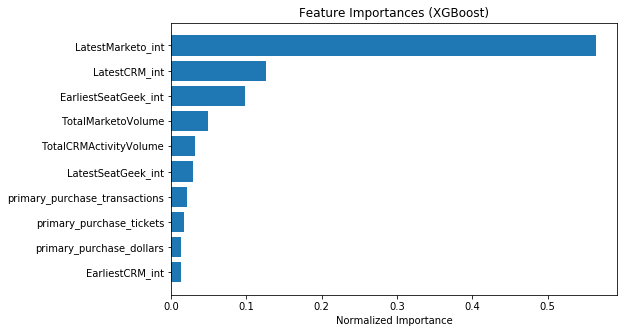

In [204]:
plot_feature_importances(model=model, model_name="XGBoost", feature_names=X_use.columns)
